# Straightforward disparate impact analysis with DAI
***
This notebooks trains a DAI surrogate model to represent the now infamous COMPAS model and performs straightforward disparate impact analysis on this surrogate model.

In [1]:
# TODO: more testing
# TODO: more annotation and comments

#### Imports

In [2]:
# file handing 
import os
import shutil
import subprocess

# basic data manipulation
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

# DAI Python client
from h2oai_client import Client

#### Global constants

In [3]:
# overall random seed
SEED = 12345

# DAI constants
DAI_HOST = 'http://localhost:12345'
DAI_USERNAME = 'phall'
DAI_PASSWORD = 'phall'
DAI_ACCURACY = 7 
DAI_TIME = 3
DAI_INTERPRETABILITY = 7

# location of results files on disk
# for previously executed long-running jobs
PREDS_FILE_PATH = 'data' + os.sep + 'preds.csv'
VARIMP_FILE_PATH = 'data' + os.sep + 'varimp.csv'

# disparate impact analysis thresholds
PARITY_THRESHOLD_L = 0.8
PARITY_THRESHOLD_H = 1.25

# 1. Fetch and clean COMPAS data

In [4]:
# fetch small data
! curl https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv -o data/compas-scores-two-years.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2486k  100 2486k    0     0  10.3M      0 --:--:-- --:--:-- --:--:-- 10.3M


In [5]:
data = pd.read_csv('data/compas-scores-two-years.csv') # read feteched data
data.drop(['name', 'first', 'last'], axis=1, inplace=True) # remove personally identifiable information (PII) 
data.drop(['priors_count.1', 'decile_score.1'], axis=1, inplace=True) # remove some duplicate columns?
print(data.shape)

(7214, 48)


In [6]:
# clean and prepare following Propublica
clean = data[data['days_b_screening_arrest'] <= 30]
clean = clean[clean['days_b_screening_arrest'] >= -30]
clean = clean[clean['is_recid'] != -1]
clean = clean[clean['c_charge_degree'] != 'O']
clean = clean[clean['score_text'] != 'N/A']

# create binary score for straightforward disparate impact analysis
clean['binary_target'] = np.where(clean['score_text'] == 'Low', 0, 1)
clean.shape

(6172, 49)

#### Inspect data

In [7]:
clean.head(n=10)

,id,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,start,end,event,two_year_recid,binary_target
0,1,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,327,0,0,0
1,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,9,159,1,1,0
2,4,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,0,63,0,1,0
5,7,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,1,853,0,0,0
6,8,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,5,40,1,1,1
7,9,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.0,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-08-30,Risk of Violence,3,Low,2013-08-30,2014-05-22,2014-06-03,0,265,0,0,0
8,10,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,2,747,0,0,0
10,14,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,0,4,0,0,0,-1.0,2013-11-25 06:31:06,2013-11-26 08:26:57,13016402CF10A,2013-11-25,NaN,1.0,F,"Poss 3,4 MDMA (Ecstasy)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-11-26,Risk of Violence,4,Low,2013-11-26,2013-11-25,2013-11-26,0,857,0,0,0
11,15,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,0,6,0,0,3,0.0,2013-10-03 04:07:35,2013-10-07 08:17:30,13018837MM10A,2013-10-03,NaN,0.0,M,Battery,1,14010414TC40A,(M2),NaN,2014-02-08,Driving License Suspended,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Medium,2013-10-03,Risk of Violence,4,Low,2013-10-03,2013-10-03,2013-10-07,4,128,1,1,1
12,16,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,0,1,0,0,0,0.0,2013-01-01 03:28:03,2013-01-02 01:12:19,13000053MM10A,2013-01-01,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-01-01,R

In [8]:
# drop less useful modeling columns
drops = list(set(clean.columns) - set(['two_year_recid','binary_target', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree', 'priors_count', 'c_charge_desc', 'race', 'sex']))
print(drops)

['score_text', 'start', 'violent_recid', 'days_b_screening_arrest', 'c_offense_date', 'vr_charge_degree', 'c_jail_in', 'c_jail_out', 'v_score_text', 'r_jail_out', 'is_violent_recid', 'is_recid', 'c_days_from_compas', 'screening_date', 'id', 'r_days_from_arrest', 'v_decile_score', 'out_custody', 'r_jail_in', 'compas_screening_date', 'decile_score', 'r_charge_degree', 'dob', 'c_case_number', 'r_offense_date', 'event', 'r_case_number', 'vr_case_number', 'v_type_of_assessment', 'age_cat', 'c_arrest_date', 'vr_offense_date', 'v_screening_date', 'in_custody', 'vr_charge_desc', 'type_of_assessment', 'r_charge_desc', 'end']


In [9]:
# create training data for DAI
clean.drop(drops, axis=1, inplace=True)
clean.to_csv('data/compas-scores-two-years-binary.csv')

# 2. Train DAI model 

In [10]:
# if previously saved results exist, use
# else train new model
if (not os.path.exists(PREDS_FILE_PATH)) or (not os.path.exists(VARIMP_FILE_PATH)):

    # connect to DAI 
    h2oai = Client(address=DAI_HOST, username=DAI_USERNAME, password=DAI_PASSWORD)

    # save training data to disk for DAI            
    cwd = os.getcwd()
    train_path_dai = (cwd + os.sep +  'data/compas-scores-two-years-binary.csv')
    train = h2oai.create_dataset_sync(train_path_dai)

    print('Training ...')
                   
    # start experiment training               
    experiment = h2oai.start_experiment_sync(
    
        # specify data 
        dataset_key=train.key, 
        validset_key='',
        testset_key='', 
    
        # specify target & input info 
        target_col='binary_target',
        is_classification=True,
        is_timeseries=False,
        cols_to_drop=['two_year_recid'],
        weight_col=None,
        fold_col=None,
        orig_time_col='[OFF]',
        time_col='[OFF]',
    
        # specify system hyperparameters
        enable_gpus=False,
        seed=SEED,
        accuracy=DAI_ACCURACY,
        time=DAI_TIME,
        interpretability=DAI_INTERPRETABILITY,
        scorer='auc')

    print('Final Model Score on Validation Data: ' + str(round(experiment.valid_score, 3)))   
    
    # generate predictions
    prediction = h2oai.make_prediction_sync(experiment.key, train_path_dai, output_margin=False, pred_contribs=False)
    preds_path = h2oai.download(prediction.predictions_csv_path, '.')
    preds = pd.read_csv(preds_path)
    preds.drop('binary_target.0', axis=1, inplace=True)
    preds.rename(columns={'binary_target.1':'p_recid'}, inplace=True)   
    
    # save predictions 
    preds.to_csv(PREDS_FILE_PATH)
    
    # housekeeping
    os.remove(preds_path)
    
    # generate and save variable importance
    summary_path = h2oai.download(src_path=experiment.summary_path, dest_dir='.')
    dir_path = cwd + os.sep + 'h2oai_experiment_summary_' + experiment.key
    subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)
    features = pd.read_table(dir_path + os.sep + 'features.txt', sep=',', skipinitialspace=True)
    
    # save variable importance
    features.to_csv(VARIMP_FILE_PATH)
    
    # housekeeping
    shutil.rmtree(dir_path)
    os.remove(summary_path)
    
else:   
    
    # load predictions 
    print('Loading predictions from disk ...\n')
    preds = pd.read_csv(PREDS_FILE_PATH, index_col=0)
    print(preds.head())
    
    # load variable importance
    print('\nLoading feature importance from disk ...\n')
    features = pd.read_csv(VARIMP_FILE_PATH, index_col=0)
    features.sort_values(by='Relative Importance', inplace=True)
    

Training ...
Final Model Score on Validation Data: 0.841


#### Plot variable importance

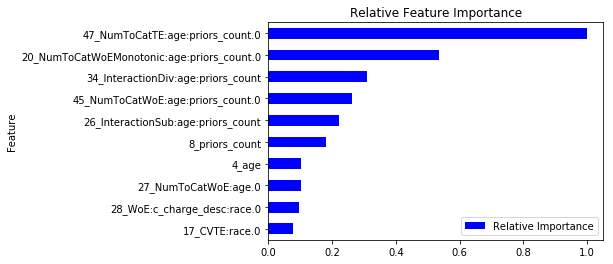

In [11]:
%matplotlib inline
features.sort_values(by='Relative Importance', inplace=True)
_ = features.loc[9:, :].plot(kind='barh', x='Feature', y='Relative Importance', color='b',
                             title='Relative Feature Importance')

# 3. Choose appropriate cutoff for model decisions

In [12]:
# merge predictions onto training data
clean.reset_index(drop=True, inplace=True)
clean_score = pd.concat([clean, preds], axis=1)
clean_score.head(n=10)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,two_year_recid,binary_target,p_recid
0,Male,69,Other,0,0,0,0,F,Aggravated Assault w/Firearm,0,0,0.023865
1,Male,34,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,1,0,0.324761
2,Male,24,African-American,0,0,1,4,F,Possession of Cocaine,1,0,0.885137
3,Male,44,Other,0,0,0,0,M,Battery,0,0,0.027845
4,Male,41,Caucasian,0,0,0,14,F,Possession Burglary Tools,1,1,0.802156
5,Male,43,Other,0,0,0,3,F,arrest case no charge,0,0,0.084318
6,Female,39,Caucasian,0,0,0,0,M,Battery,0,0,0.104858
7,Male,27,Caucasian,0,0,0,0,F,"Poss 3,4 MDMA (Ecstasy)",0,0,0.358221
8,Male,23,African-American,0,0,0,3,M,Battery,1,1,0.868458
9,Female,37,Caucasian,0,0,0,0,M,Battery,0,0,0.129147


#### Calculate ROC from cross-validated model on out-of-time results

In [13]:
def get_prroc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-100 # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame
        
prroc_frame = get_prroc(clean_score, 'two_year_recid', 'p_recid')

#### Select cutoff based on F1
You can try other cutoffs as well.

In [14]:
best_cut = prroc_frame.loc[prroc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1

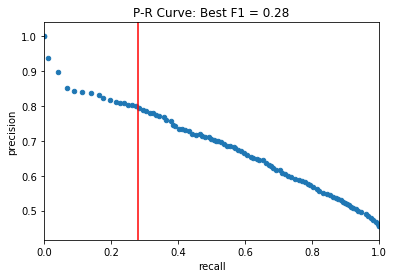

In [15]:
# Plot P-R ROC w/ best cutoff
title_ = 'P-R Curve: Best F1 = ' + str(best_cut)
ax = prroc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

# 4. Disparate impact analysis 

#### View overall confusion matrix

In [16]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[i, j] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    return cm_frame
    
    
get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', cutoff=best_cut)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,2215,594
predicted: 0,1628,1735


#### View confusion matrices by race

In [17]:
races = list(clean_score['race'].unique())
races

['Other',
 'African-American',
 'Caucasian',
 'Hispanic',
 'Asian',
 'Native American']

In [18]:
other_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Other', cutoff=best_cut)
other_cm

Confusion matrix by race=Other


,actual: 1,actual: 0
predicted: 1,60,64
predicted: 0,47,172


In [19]:
afam_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='African-American', cutoff=best_cut)
afam_cm

Confusion matrix by race=African-American


,actual: 1,actual: 0
predicted: 1,1500,161
predicted: 0,1053,461


In [20]:
cauc_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Caucasian', cutoff=best_cut)
cauc_cm

Confusion matrix by race=Caucasian


,actual: 1,actual: 0
predicted: 1,536,286
predicted: 0,438,843


In [21]:
hisp_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Hispanic', cutoff=best_cut)
hisp_cm

Confusion matrix by race=Hispanic


,actual: 1,actual: 0
predicted: 1,108,81
predicted: 0,83,237


In [22]:
asian_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Asian', cutoff=best_cut)
asian_cm

Confusion matrix by race=Asian


,actual: 1,actual: 0
predicted: 1,6,2
predicted: 0,3,20


In [23]:
natam_cm = get_confusion_matrix(clean_score, 'two_year_recid', 'p_recid', by='race', level='Native American', cutoff=best_cut)
natam_cm

Confusion matrix by race=Native American


,actual: 1,actual: 0
predicted: 1,5,0
predicted: 0,4,2


#### Define several metrics for measuring disparity

In [24]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much recidivism actually happens for this group
'Accuracy':   '(tp + tn) / (tp + tn +fp + fn)', # how often the model predicts recidivism correctly for this group

#### predicting recedivism will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* recidivate, how many the model predicted *correctly* would recidivate              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would recidivate, how many the model predicted *correctly* would recidivate

#### predicting recedivism won't happen
# (correctly)
'Specificity':              'tn / (fp + tn)', # out of the people in the group *that did not* recidivate, how many the model predicted *correctly* would not recidivate
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not recidivate, how many the model predicted *correctly* would not recidivate  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (fp + tn)', # out of the people in the group *that did not* recidivate, how many the model predicted *incorrectly* would recidivate
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would recidivate, how many the model predicted *incorrectly* would recidivate

#### analyzing errors - type II
# dangerous ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* recidivate, how many the model predicted *incorrectly* would not recidivate
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not recidivate, how many the model predicted *incorrectly* would not recidivate
}    

In [25]:
# small utility function
# translates abbreviated metric expressions into executable statements
def cm_exp_parser(expression):
    
    # tp | fp       # cm_list[i].iat[0, 0] | cm_list[i].iat[0, 1]
    # -------  ==>  # --------------------------------------------
    # fn | tn       # cm_list[i].iat[1, 0] | cm_list[i].iat[1, 1]

    expression = expression.replace('tp', 'cm_list[i].iat[0, 0]')\
                           .replace('fp', 'cm_list[i].iat[0, 1]')\
                           .replace('fn', 'cm_list[i].iat[1, 0]')\
                           .replace('tn', 'cm_list[i].iat[1, 1]')

    return expression


#### Calculate all metrics across all races

In [26]:
# initialize list of confusion matrices and corresponding rows of dataframe
cm_list = [other_cm, afam_cm, cauc_cm, hisp_cm, asian_cm, natam_cm] 
metrics_frame = pd.DataFrame(index=races) # frame for metrics

# nested loop through:
# - confusion matrices
# - races
# - metrics 
for cm in cm_list:
    for i, race in enumerate(races):
            for metric in metric_dict.keys():
              
                # parse metric expressions into executable pandas statements
                expression = cm_exp_parser(metric_dict[metric])
                
                # dynamically evaluate metrics to avoid code duplication
                metrics_frame.loc[race, metric] = eval(expression)  

# display results                
metrics_frame

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
Other,0.311953,0.676385,0.560748,0.483871,0.728814,0.785388,0.271186,0.516129,0.439252,0.214612
African-American,0.804094,0.617638,0.587544,0.903070,0.741158,0.304491,0.258842,0.096930,0.412456,0.695509
Caucasian,0.463148,0.655730,0.550308,0.652068,0.746678,0.658080,0.253322,0.347932,0.449692,0.341920
Hispanic,0.375246,0.677800,0.565445,0.571429,0.745283,0.740625,0.254717,0.428571,0.434555,0.259375
Asian,0.290323,0.838710,0.666667,0.750000,0.909091,0.869565,0.090909,0.250000,0.333333,0.130435
Native American,0.818182,0.636364,0.555556,1.000000,1.000000,0.333333,0.000000,0.000000,0.444444,0.666667


#### Calculate disparate impact against reference level, i.e. Caucasian, for all races and metrics

In [27]:
ref_level = 'Caucasian'

# init frame to store disparity measures
disp_frame = pd.DataFrame(index=races, 
                          columns=[col + ' Disparity' for col in metrics_frame.columns])

# compare all metrics to reference level
disp_frame = metrics_frame/metrics_frame.loc[ref_level, :]

# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (PARITY_THRESHOLD_L < val < PARITY_THRESHOLD_H) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
Other,0.67355,1.0315,1.01897,0.742056,0.976074,1.19345,1.07052,1.48342,0.976785,0.627666
African-American,1.73615,0.941909,1.06766,1.38493,0.992606,0.462697,1.02179,0.278588,0.917197,2.03412
Caucasian,1,1,1,1,1,1,1,1,1,1
Hispanic,0.810207,1.03366,1.02751,0.876333,0.998131,1.12543,1.00551,1.23177,0.966339,0.758583
Asian,0.626846,1.27905,1.21144,1.15019,1.21751,1.32137,0.358868,0.718531,0.741248,0.381477
Native American,1.76657,0.970466,1.00954,1.53358,1.33926,0.506524,0,0,0.988331,1.94977


#### Check parity for each metric and for a few overall measures

In [28]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

# init frame for parity
par_frame = pd.DataFrame(index=races, 
                         columns=[col + ' Parity' for col in metrics_frame.columns])
# nested loop through: 
# - races
# - disparity metrics
for i, _ in enumerate(races):
    for j, _ in enumerate(par_frame.columns):
        par_frame.iat[i, j] = (PARITY_THRESHOLD_L < disp_frame.iat[i, j] < PARITY_THRESHOLD_H)

# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all attributes
par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
par_frame['Overall Fairness'] = par_frame.all(axis='columns')
    
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 
    
par_frame.style.applymap(color_false_red)
       

,Prevalence Parity,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
Other,False,True,True,False,True,True,True,False,True,False,False,False,True,False,False
African-American,False,True,True,False,True,False,True,False,True,False,False,False,True,False,False
Caucasian,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Hispanic,True,True,True,True,True,True,True,True,True,False,True,False,True,False,False
Asian,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False
Native American,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False
